In [22]:
# keras supplied image generator
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2DTranspose, Conv2D, UpSampling2D, Reshape, Flatten, MaxPooling2D, LeakyReLU
from keras.optimizers import RMSprop, SGD
from IPython.display import Image, display
from itertools import repeat
import PIL
from datetime import datetime

import numpy as np

#the size for both the real and the fake data
partial_batch_size = 64
scale_up = 4

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.005,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

read_data_gen = datagen.flow_from_directory(os.getcwd()+'/training/', target_size=(64,64),batch_size=partial_batch_size)

def output_to_image(array):
    array = array*127.5+127.5
    i = array_to_img(array).resize((64*scale_up,64*scale_up), PIL.Image.ANTIALIAS)
    return i


Found 729 images belonging to 3 classes.


Generator is based off of `UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS` available [here](https://arxiv.org/abs/1511.06434)

In [23]:
def get_generator():
    m = Sequential()
    m.add(Dense((4*4*1024), input_shape=(100,), activation = 'relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(Reshape((4,4,1024)))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(512,8, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(256,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(128,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(64,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(Conv2DTranspose(3,5, activation = 'sigmoid', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    return m

generator_model = get_generator()
generator_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
dropout_30 (Dropout)         (None, 16384)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 512)         33554944  
_________________________________________________________________
dropout_31 (Dropout)         (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 16, 16, 512)       0         
__________

This network takes 100 random numbers and generates an eye from it (once it's been trained). 

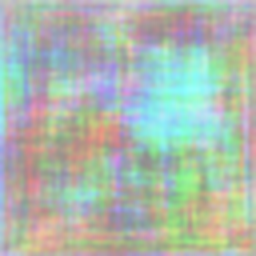

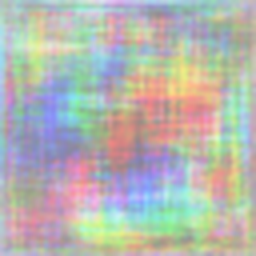

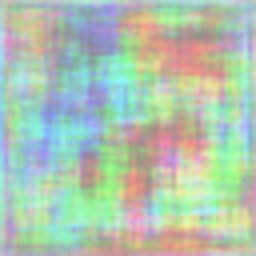

In [24]:
sample_in = np.random.uniform(-1, 1, (3,100))

sample_out = generator_model.predict(sample_in)

for a in sample_out:
    display(output_to_image(a))

For comparison, here are some real images:

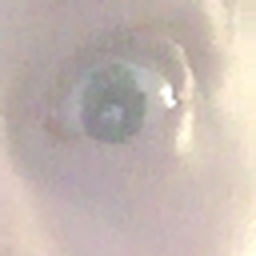

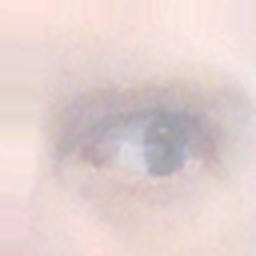

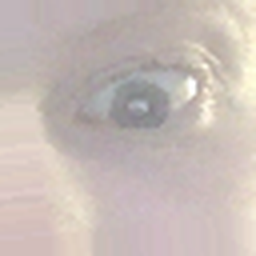

In [25]:

for eye in next(read_data_gen)[0][1:4]:
    display(output_to_image(eye))

For simplicity, we'll use a simple classifier from [Keras's blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [26]:
def get_descriminator():
    m = Sequential()
    m.add(Conv2D(32,3, input_shape=(64,64,3,), activation = LeakyReLU(), padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.5))
    m.add(Conv2D(32,3, activation = LeakyReLU(), padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.5))
    m.add(Conv2D(64,3, activation = LeakyReLU(), padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.5))
    m.add(Flatten())
    m.add(Dense(1, activation = 'sigmoid'))
    return m

descriminator = get_descriminator()
descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
__________

Finally we'll combine and compile the two models:

In [27]:
def compile(descriminator, generator):
    combined = Sequential()
    combined.add(generator)
    combined.add(descriminator)
    combined.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001))
    
    descriminator.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001))
    generator.compile(loss='mean_squared_error', optimizer=SGD(lr=0.0001, momentum = .9, nesterov = True))
    return combined, descriminator, generator

combined, descriminator, generator = compile(get_descriminator(), get_generator())
    
# not as exciting as it could be...
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 64, 64, 3)         39515779  
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 32737     
Total params: 39,548,516.0
Trainable params: 39,548,516.0
Non-trainable params: 0.0
_________________________________________________________________


Now all we have to do is train it.

In [ ]:
def fit(steps = 10000):
    
    def gen_data():
        real = next(read_data_gen)[0]
        
        # if the number of real images isn't evenly divided by the target batch size, this will be different at the end
        actual_batch_size = len(real)
        
        fake_in = np.random.uniform(-1, 1, (actual_batch_size,100))
        fake = generator.predict(fake_in)
        
        x = np.concatenate((real,fake))
        y = np.ones([actual_batch_size*2,1])
        y[actual_batch_size:,:] = 0
        
        return x, y, fake_in


    x, y, fake_in = gen_data()
    #descriminator.fit(x,y, epochs = 100, verbose = True)
    
    fake_in = np.random.uniform(-1, 1, (partial_batch_size,100))
    y = np.ones([partial_batch_size,1])
        
        
    for i in range(0,1):
        descriminator.trainable = False
        # c_err = combined.fit(fake_in, y, epochs = 5, verbose = True)
        descriminator.trainable = True
        print(y)
        print(combined.predict(fake_in))
        sample = generator.predict(fake_in)[0]
        display(output_to_image(sample))
        #print(str(c_err.history))
    
    last_x = None
    last_y = None
    
    for step in range(steps):
        x, y_all, fake_in = gen_data()
        #print(combined.metrics_names)
        
        if last_x is None or last_y is None:
            last_x = x
            last_y = y_all
        
        # d is slower than g to converge, so train it extra times
        for repeat in range(0, 3):
            d_err = descriminator.train_on_batch(np.concatenate((x,last_x)),np.concatenate((y_all, last_y)))
        
        last_x = x
        last_y = y_all
        
        y = np.ones([len(fake_in),1])
        
        for layer in descriminator.layers:
            layer.trainable = False
        c_err = combined.train_on_batch(fake_in, y)
        #print(y)
        #print(combined.predict(fake_in))
        for layer in descriminator.layers:
            layer.trainable = True
            
        sample = generator.predict(fake_in)[0]

        if step % 10 == 0:
            display(output_to_image(sample))
            # print(descriminator.predict(x))
            # print(y_all)
            # print(combined.predict(fake_in))
        print("%s: Step: %d, Descriminator: %f, Generator: %f"%(str(datetime.now()), step, d_err, c_err))
        
        
fit()
        